### Object Detection View
select random 3 img to show object detection;confidence_score > 0.5 will save the feature into csv;

# Imports

In [69]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import random

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

## Env setup

In [70]:
# This is needed to display the images.
%matplotlib inline

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("../../")

## Object detection imports
Here are the imports from the object detection module.

In [71]:
from util import label_map_util

from util import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [72]:
# What model to download.
BASE_MODEL_PATH = '/home/zutnlp/data/ssd_mobilenet_v1_coco_11_06_2017'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = BASE_MODEL_PATH + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = '/home/zutnlp/data/label_mapping/mscoco_label_map.pbtxt'

#Path for Ai Challenge train data
PATH_TO_AI_CHALLENGE_TRAIN = '/home/zutnlp/data/challenger_train/ai_challenger_caption_train_20170902/caption_train_images_20170902'

NUM_CLASSES = 90

## Load a (frozen) Tensorflow model into memory.

In [73]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [74]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

## Helper code

In [75]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)
def iterbrowse(path):
    for home, dirs, files in os.walk(path):
        for filename in files:
            yield os.path.join(home, filename)

# Detection

In [76]:
# gen  img feature for ai challenge train data :
TRAIN_IMAGE_PATHS = []
for full_path in iterbrowse(PATH_TO_AI_CHALLENGE_TRAIN):
    TRAIN_IMAGE_PATHS.append(full_path)
print('train data size: '+ str(len(TRAIN_IMAGE_PATHS)))
IMAGE_SIZE = (12, 8)

train data size: 210000


# img feature example
## filename,width,height,class,xmin,ymin,xmax,ymax  
 5ee9ec8cba6eda45f3eba5d70e11b7539abe1e21,696,1024,person,27.04481291770935,134.61184692382812,651.7708625793457,710.9619140625
 5ee9ec8cba6eda45f3eba5d70e11b7539abe1e21,696,1024,sport sball,577.87563085,493.366821289,651.0675702,638.5460205078125
 
## full img feature path: /home/zutnlp/data/label_mapping/ai_challenge_labels.csv 

### random select 3 img from ai challenge data to show

/home/zutnlp/data/challenger_train/ai_challenger_caption_train_20170902/caption_train_images_20170902/6e16e0d2a3ab7b2b056435d70898ef53782abfb4.jpg
/home/zutnlp/data/challenger_train/ai_challenger_caption_train_20170902/caption_train_images_20170902/44a93a00034e5b32a120273287650f2047fbb695.jpg
/home/zutnlp/data/challenger_train/ai_challenger_caption_train_20170902/caption_train_images_20170902/922aaba845b295398aecb754bebdb2c37dc468ea.jpg


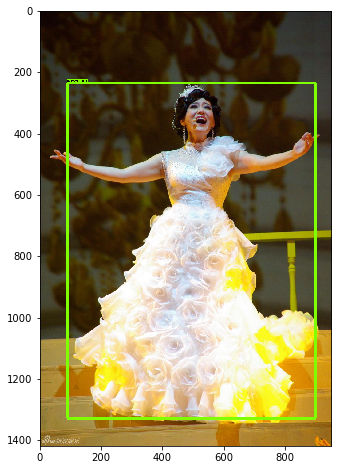

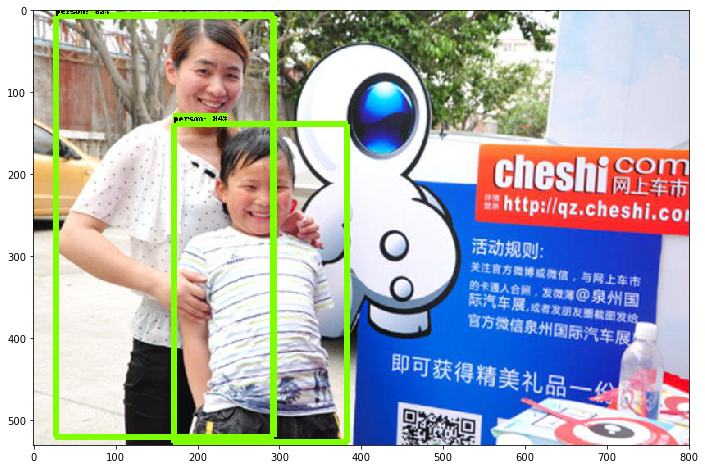

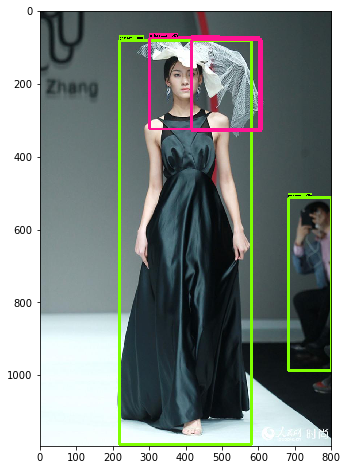

In [80]:
with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    # Definite input and output Tensors for detection_graph
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    # Each box represents a part of the image where a particular object was detected.
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    for image_path in  random.sample(TRAIN_IMAGE_PATHS,3):
      image = Image.open(image_path)
      # the array based representation of the image will be used later in order to prepare the
      # result image with boxes and labels on it.
      image_np = load_image_into_numpy_array(image)
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
      # Actual detection.
      (boxes, scores, classes, num) = sess.run(
          [detection_boxes, detection_scores, detection_classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      # Visualization of the results of a detection.
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,
          use_normalized_coordinates=True,
          line_thickness=8)
      plt.figure(figsize=IMAGE_SIZE)
      plt.imshow(image_np)
      print (image_path)